In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from vivarium_helpers.prob_distributions import plotting, fit

!date
!whoami
!uname -a
!pwd

Fri Feb 17 16:21:30 PST 2023
ndbs
Darwin ndbs-Q9Q94K6GHF 21.6.0 Darwin Kernel Version 21.6.0: Mon Dec 19 20:43:09 PST 2022; root:xnu-8020.240.18~2/RELEASE_ARM64_T6000 arm64
/Users/ndbs/repos/vivarium_data_analysis/probability


# Can we construct a uniform distribution from a mixture of Beta distributions of varying mean or mode?

I want to compute the mixture of some family of Beta distributions whose peak varies from 0 to 1. In particular, is there such a family whose mixture is the uniform distribution on [0,1]? It's a long shot to correctly guess such a parameterization, but hey, let's try it!

My original interest in this problem was for generating correlated noise for the Probabalistic Record Linkage (PRL) project. I want each simulant to have a propensity for producing noisy records, so that noise will be correlated between columns and/or between datasets. I want to generate the propensity in two steps:

1. Rank the simulants from $1$ to $N$, where $N$ is the number of simulants, according to some simple, deterministic "scoring" rule where higher scores correspond to more noise.

   1. For example, we could choose several simulant attributes that we think might lead to a simulant having noisier records (e.g., income, race/ethnicity, new parenthood, recent move, unemployment), arbitrarily assign scores to each attribute, and add up the scores for each attribute for each simulant when the observation happens.
   
   1. Rank the simulants from lowest score to highest score, and break ties arbitrarily.
   
1. Let $\operatorname{rank}(k)$ denote the rank of simulant $k$ according to some "noise score function" as described above. To define the noise propensity $Q_k$ for simulant $k$, sample $Q_k$ from a Beta distribution with, e.g., mode or mean $\operatorname{rank}(k)/N$ and a fixed "concentration" parameter that controls how spread out the Beta distributions are. If the Beta distributions can be parameterized in such a way that their mixture is uniform, then for large $N$, the random variable $Q$ defined by uniformly sampling $k$ and then setting $Q = Q_k$ will be uniformly distributed, hence a valid propensity that can be used for, e.g., inverse transform sampling.

The point is to add randomness to the simplistic, deterministic ranking function so that we don't have to be too careful in designing it. 

# Define some parameterizations of beta distributions

https://en.wikipedia.org/wiki/Beta_distribution#Alternative_parameterizations

We define the "concentration" of the beta distribution $\operatorname{Beta}(\alpha,\beta)$ to be $c = \alpha+\beta-2$.

In [2]:
def beta_dist_from_mean_and_concentration(mean, conc):
    alpha = mean * (conc+2)
    beta = (1-mean) * (conc+2)
    return stats.beta(a=alpha, b=beta)

def beta_dist_from_mode_and_concentration(mode, conc):
    alpha = 1 + mode*conc
    beta = 1 + (1-mode)*conc
    return stats.beta(a=alpha, b=beta)

# Plot beta densities parameterized by mean or mode with fixed concentration

Parameterizing by mean concentrates more mass near the boundaries 0 and 1 than parameterizing by mode. This makes sense since the density will have an asymptote at the boundary as the mean approaches 0 or 1 (i.e., we should get $\alpha<1$ as the mean approaches 0 or $\beta<1$ as the mean approaches 1), whereas setting the mode equal to 0 or 1 makes $\alpha=1$ or $\beta=1$, respectively, so the density stays bounded.

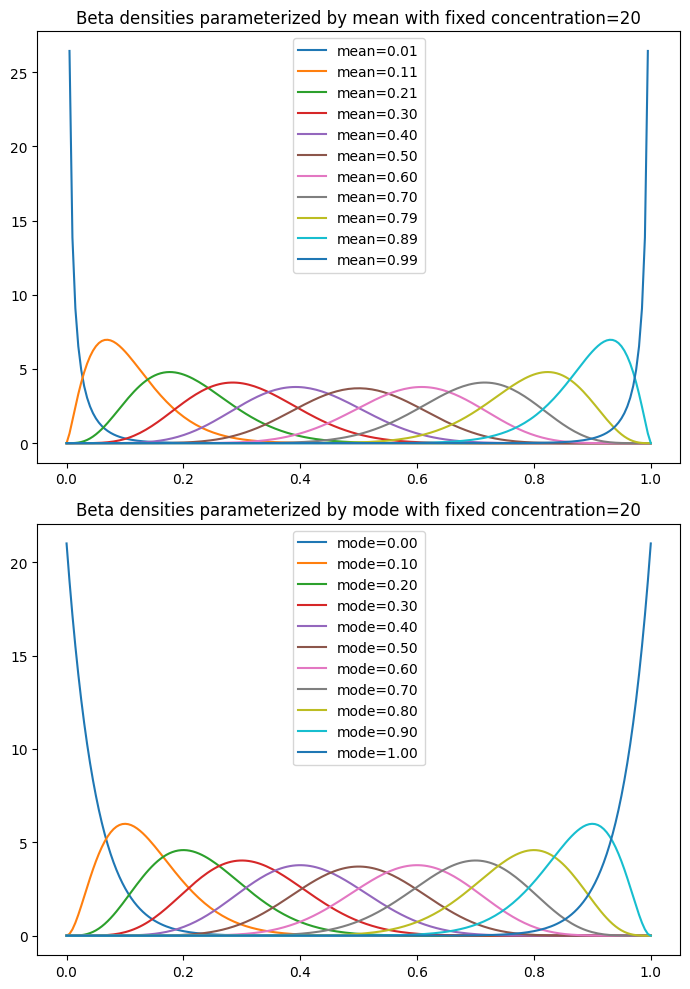

In [131]:
fig, axs = plt.subplots(2,1, figsize=(7,10))

x = np.linspace(0,1,200)
conc = 20
means = np.linspace(0.01, 0.99, 11)
modes = np.linspace(0,1,11)

for mean in means:
    dist = beta_dist_from_mean_and_concentration(mean, conc)
    axs[0].plot(x, dist.pdf(x), label=f'mean={mean:.2f}')
    
for mode in modes:
    dist = beta_dist_from_mode_and_concentration(mode, conc)
    axs[1].plot(x, dist.pdf(x), label=f'mode={mode:.2f}')

axs[0].set_title(f"Beta densities parameterized by mean with fixed concentration={conc}")
axs[0].legend()
axs[1].set_title(f"Beta densities parameterized by mode with fixed concentration={conc}")
axs[1].legend()
fig.tight_layout()

# Plot mixture densities for mixtures over mean or mode with various fixed concentrations

Using mean as the mixing variable undershoots the uniform distribution around the midpoint 0.5, and overshoots the uniform distribution near the boundary $\{0,1\}$ (I'm guessing the anomalous graph for $c=100$ is due to numerical precision error). This agrees with the note above that parameterizing the Beta distributions by mean will concentrate more mass near the boundaries. The mixture distribution approaches the uniform distribution as the concentration goes to $\infty$, which makes sense because the Beta distribution with mean $x$ and concentration $c$ will approach $\delta_x$, the Dirac measure (point mass) at $x$ as $c\to\infty$, and a uniform mixture of $\delta_x$ over $x$ is a uniform distribution.

Using mode as the mixing variable, it appears that the mixture approaches the uniform distribution both as $c\to 0$ and $c\to\infty$, whereas for $0<c<\infty$, the mixture overshoots the uniform distribution around the center and undershoots it near the boundary (opposite of what happens with the mean).

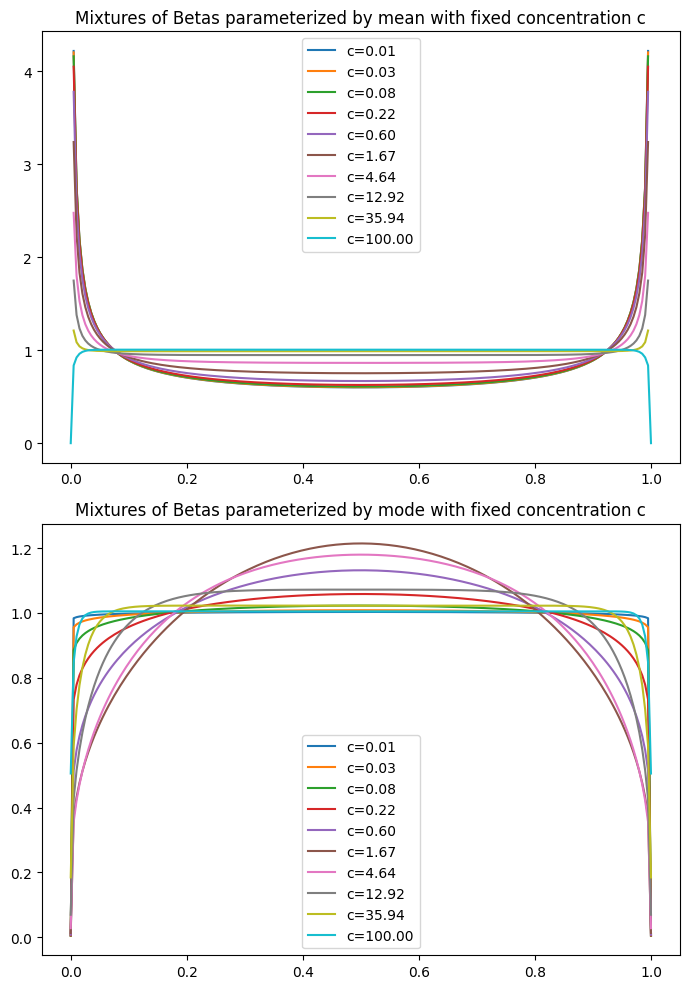

In [127]:
fig, axs = plt.subplots(2,1, figsize=(7,10))

num_dists = 200
means = np.linspace(0.01, 0.99, num_dists)
modes = np.linspace(0, 1, num_dists)

# concentrations = np.linspace(0.01, 100, 10)
concentrations = np.logspace(-2, 2, 10)

for conc in concentrations:
    mean_dists = [beta_dist_from_mean_and_concentration(mean, conc) for mean in means]
    mode_dists = [beta_dist_from_mode_and_concentration(mode, conc) for mode in modes]

    x = np.linspace(0,1,200)
    mean_mixture_pdf = sum(dist.pdf(x) for dist in mean_dists) / num_dists
    mode_mixture_pdf = sum(dist.pdf(x) for dist in mode_dists) / num_dists

    axs[0].plot(x, mean_mixture_pdf, label=f'c={conc:.2f}')

    axs[1].plot(x, mode_mixture_pdf, label=f'c={conc:.2f}')

axs[0].set_title("Mixtures of Betas parameterized by mean with fixed concentration c")
axs[0].legend()
axs[1].set_title("Mixtures of Betas parameterized by mode with fixed concentration c")
axs[1].legend()
fig.tight_layout()

# Check some stuff

In [55]:
conc = 5
mean_dists = [beta_dist_from_mean_and_concentration(mean, conc) for mean in means]
mode_dists = [beta_dist_from_mode_and_concentration(mode, conc) for mode in modes]
[dist.var() for dist in mean_dists]

[0.0012375,
 0.012041999999999999,
 0.020445500000000002,
 0.026448,
 0.0300495,
 0.03125,
 0.0300495,
 0.026448,
 0.020445499999999995,
 0.012041999999999997,
 0.001237500000000001]

In [57]:
[dist.var() for dist in mode_dists]

[0.015306122448979591,
 0.021045918367346938,
 0.025510204081632654,
 0.028698979591836735,
 0.030612244897959183,
 0.03125,
 0.03061224489795918,
 0.028698979591836732,
 0.02551020408163265,
 0.021045918367346938,
 0.015306122448979591]

# Try stretching

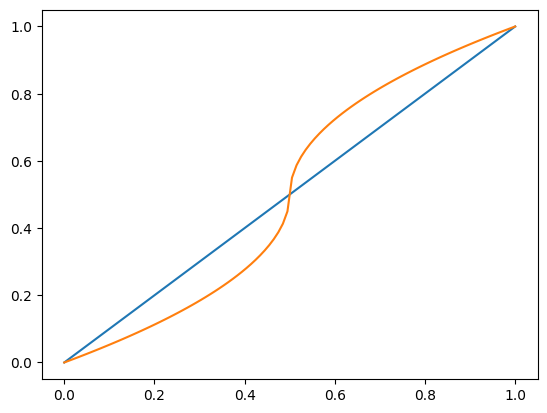

In [134]:
def power_stretch(x, p):
    y = (2*(x - 1/2)) # Transform [0,1] -> [-1,1]
    y = np.sign(y)*np.abs(y)**p
    y = y/2 + 1/2 # Transform [-1,1] -> [0,1]
    return y

x = np.linspace(0, 1, 100)
plt.plot(x, x)
plt.plot(x, power_stretch(x, 1/2))